In [1]:
import pandas as pd

import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster, to_tree, dendrogram, linkage
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from scipy.spatial.distance import squareform
import numpy as np
import seaborn as sns
from pathlib import Path


In [2]:
from module.dendrogram_utils import dendrogram_clustering
from module.gramchd.gmd import sort_adjacencies, distance_stats, perform_matching_distance
from module.gramchd.nhood import get_io_top_NM, get_io_top_M
# from src.nhood_vis import df_to_graph
from module.gramchd.nhood_vis import plot_two_graphs_overlay, plot_two_graphs_from_output
from module.utils import get_neighbourhood, get_w_threshold

/Users/ssm47/opt/anaconda3/envs/thesis_env/lib/python3.9/site-packages/graspologic/layouts/colors.py:13: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/ssm47/opt/anaconda3/envs/thesis_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from module.wegog_utils import get_ego_top_NM, prepare_nhood_graphs, perform_matching, matching_distance, df_to_graph


In [4]:
datadate = '20231124'
nb_name = '02b_nhood_stats'

cwd = Path.cwd()
save_things=False
if save_things:
    fig_dir = cwd.parent / 'figures' / nb_name
    fig_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
vnc_edges = pd.read_csv(f'../../data/vnc/{datadate}_data/manc_edges_{datadate}.csv', index_col=0)

vnc_edges = vnc_edges.groupby(['bodyId_pre', 'bodyId_post'], as_index=False).weight.sum()
vnc_edges.rename(columns={'bodyId_pre':'pre', 'bodyId_post':'post'}, inplace=True)
vnc_meta = pd.read_csv(f'../../data/vnc/{datadate}_data/manc_meta_{datadate}.csv', index_col=0)

In [ ]:
save_things = True

# Degree and weight distributions:

In [ ]:
dw_dist_plot_data = [(np.log10(vnc_edges.groupby('post').pre.count()), np.log10(vnc_edges.groupby('pre').post.count())),
                     (np.log10(vnc_edges.groupby('post').weight.sum()),np.log10(vnc_edges.groupby('pre').weight.sum()))]

# neighbourhood stats:

In [ ]:
heminames = ['07B', '11A', '11B', '02A', '18B', '12A', '01A', '10B', '06A', \
             '06B', '19A', '21A', '03B', '23B', '12B', '13B', '05B', '20A.22A', \
             '08A', '09A']

n_ids = list(set(vnc_meta[(vnc_meta['hemilineage'].isin(heminames))].bodyId.values)) # the integers have the numpy.int64 datatype!
n_ids = sorted(n_ids)

In [ ]:
M=50

In [ ]:
heminame = '09A'

motifs = ['independent leg', 'sequential']
n_ids = list(set(vnc_meta[(vnc_meta['hemilineage']==heminame)&(vnc_meta['serialMotif'].isin(motifs))].bodyId.values)) # the integers have the numpy.int64 datatype!
len(n_ids)

218

In [ ]:
n_ids_meta = vnc_meta[vnc_meta['bodyId'].isin(n_ids)].copy(True).set_index('bodyId')
n_ids_meta.index = n_ids_meta.index.astype('str')
n_ids_ptn = get_neighbourhood(Ids=n_ids, df=vnc_edges)
pp_set = set(n_ids_ptn[['pre', 'post']].to_numpy().flatten())
n_ids_nhood = vnc_edges[vnc_edges['post'].isin(pp_set) & vnc_edges['pre'].isin(pp_set)].sort_index().copy(True)
n_ids_nhood.loc[:,'attr'] = n_ids_nhood.weight.apply(lambda x: {'weight':x})


In [ ]:
partner_df = get_io_top_M(Id=n_ids[1], df=vnc_edges, M=None).reset_index(drop=True)
total_weights = partner_df.iloc[:, 1:].sum(axis=0).to_dict()

partner_cum_sum_df = partner_df.iloc[:,1:].cumsum(axis='index')
normed_partner_cum_sum_df = partner_cum_sum_df.div(total_weights) # normalised by total

In [ ]:
ids =n_ids
Ms = [30,50,80,100]
ego_stats = []
for i in ids[:]:
    total_ego = get_ego_top_NM(Id=i, df=vnc_edges, M=None, N=None)
    total_ego_weight = total_ego.weight.sum()
    total_ego_nedges = len(total_ego)
    
    ego_data= {'id':i, 't_ego_w':total_ego_weight, 't_ego_e':total_ego_nedges}
    for m in Ms:
        i_ego = get_ego_top_NM(Id=i, df=vnc_edges, M=m, N=None)
        m_ego_weight = i_ego.weight.sum()
        m_ego_nedges = len(i_ego)
        ego_data[f'{m}_ego_w'] = m_ego_weight
        ego_data[f'{m}_ego_e'] = m_ego_nedges
    ego_stats.append(ego_data)
    
# ~2 min 14s

# 

In [ ]:
ego_stats_df = pd.DataFrame(ego_stats)

In [ ]:
e_names = [i for i in ego_stats_df.columns.tolist() if 'ego_e' in i][1:]

w_names = [i for i in ego_stats_df.columns.tolist() if 'ego_w' in i][1:]

In [ ]:
ego_stats_copy = ego_stats_df.copy(True)

In [ ]:
for en in e_names:
    ego_stats_copy[en] = ego_stats_copy[en]/ego_stats_copy['t_ego_e']

In [ ]:
for en in w_names:
    ego_stats_copy[en] = ego_stats_copy[en]/ego_stats_copy['t_ego_w']

In [ ]:
e_means = []
e_sems = []
for en in e_names:
    mean = ego_stats_copy[en].mean()
    sem = ego_stats_copy[en].sem()
    e_means.append(mean)
    e_sems.append(sem)

In [ ]:
w_means = []
w_sems = []
for en in w_names:
    mean = ego_stats_copy[en].mean()
    sem = ego_stats_copy[en].sem()
    w_means.append(mean)
    w_sems.append(sem)

In [ ]:
# plt.figure(figsize=(5,4))
# plt.errorbar(Ms,e_means, yerr=e_sems, label='Edge proportion', capsize=5)
# plt.errorbar(Ms,w_means, yerr=w_sems, label = 'Weight proportion', capsize=5)
# plt.legend(fontsize=15)
# plt.xlabel('Neighbourhood size', size=20)
# plt.ylabel('Proportion of total', size=20)
# plt.xticks(size=15)
# plt.yticks(size=15)

# plt.show()

# total figure:

/var/folders/hk/bsx9hgyx4t16l4wbtx2vwmcw0000gp/T/ipykernel_9394/3711360786.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


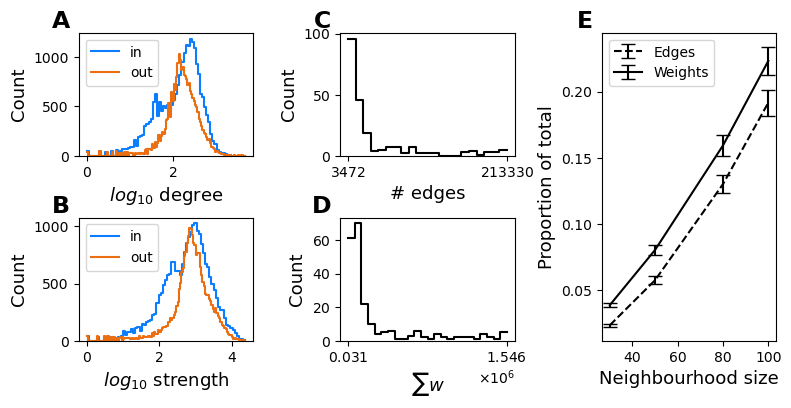

In [ ]:
fig = plt.figure(figsize=(9, 4))
gs = GridSpec(nrows=1, ncols=3, figure=fig, width_ratios=[1,1,1], wspace=0.5)  # 2x2 grid
gs1 = GridSpecFromSubplotSpec(nrows=2, ncols=1, subplot_spec=gs[0], hspace=0.5)
gs2 = GridSpecFromSubplotSpec(nrows=2, ncols=1, subplot_spec=gs[1], hspace=0.5)

ax1 = fig.add_subplot(gs1[0])
ax2 = fig.add_subplot(gs1[1])
ax3 = fig.add_subplot(gs2[0])
ax4 = fig.add_subplot(gs2[1])
ax5 = fig.add_subplot(gs[2])

for ax, data, title in zip([ax1, ax2], dw_dist_plot_data, [r'$log_{10}$ degree', r'$log_{10}$ strength']):
    sns.histplot(data[0], fill=False,  element='step', label='in', ax=ax, color="#0B7DFF") # in
    sns.histplot(data[1], element='step', fill=False, label='out', ax=ax, color="#EB6F10")# out
    ax.set_xlabel(title,size=13)
    ax.set_ylabel(r'Count', size=13)
    ax.legend(fontsize=10)
    

for ax, data, title in zip([ax3, ax4], [ego_stats_df.t_ego_e.values, ego_stats_df.t_ego_w.values], ['# edges', '$\sum w$']):
    
    sns.histplot(data, fill=False,  element='step', ax=ax, color='black') # in
    lims = [data.min(), data.max()]
    ax.set_xlabel(title,size=13)
    ax.set_xticks(lims)
    ax.set_ylabel(r'Count', size=13)
    ax.ticklabel_format(useMathText=True)
    # ax.set_xscale('log')
    # ax.legend(fontsize=10)


# plt.figure(figsize=(5,4))
ax5.errorbar(Ms,e_means, yerr=e_sems, label='Edges', capsize=5, color='black', linestyle='--')
ax5.errorbar(Ms,w_means, yerr=w_sems, label = 'Weights', capsize=5, color='black')
ax5.legend(fontsize=10)
ax5.set_xlabel('Neighbourhood size', size=13)
ax5.set_ylabel('Proportion of total', size=13)
ax5.tick_params('y',labelsize=10)
ax5.tick_params('x',labelsize=10)



for ax, text in zip([ax1,ax2,ax3,ax4, ax5], 'ABCDE'):
    ax.text(-0.05, 1, text, transform=ax.transAxes, fontsize=17, fontweight='bold', va='bottom',  ha='right')
# plt.show()
plt.tight_layout()
if save_things:
    plt.savefig(f'../figures/{nb_name}/nhood_stats.png', transparent=True, dpi=300, bbox_inches='tight')
    plt.savefig(f'../figures/{nb_name}/nhood_stats.pdf', transparent=True, dpi=300, bbox_inches='tight')

plt.show()